# 📝 IBM HR 분석: 직원 이직 및 성과 
### (IBM HR Analytics Employee Attrition & Performance)

- ⭐목표: 직원 이직 여부를 예측하는 모델을 구축하고, 직원의 이직 원인과 관련된 인사이트를 도출<br>
- ⭐예상 결과: 모델을 통해 향후 이직할 가능성이 있는 직원을 예측하고 조직의 인사 전략 대응 및 개선 방향
    - 가설: 1) MonthlyIncome 이 낮을수록 이직률이 낮을 가능성 2) JobSatisfaction 가 클수록 이직 낮을 가능성 3) OverTime 이 No 일때 이질률 늦을 가능성
- ⭐아키텍처 정의: 데이터 수집, 데이터 처리, 데이터분석, 시각화, 머신러닝 모델링생성 및 평가
- ⭐개발 및 환경 구축: 
     - PySpark 의한 데이터 처리
     - Python 데이터 분석 및 머신모델을 위한 언어
     - Jupyter Notebook 코드 실행 및 결과 확인을 위한 인터페이스
     - AWS EC2 클라우드 환경 사용
     - GitHub: 코드 백업

- ⭐계발 계획
    1. 데이터수집
    2. 데이터 전처리
    3. 탐색적 데이터 분석 (EDA) 
    4. 머신러닝 모델링
        - 모델링 접근: 종속변수(Attrition, YES or NO)가 이진(binary) 형태여서 Logistic Regression 분석
        - 이직 여부와 각 독립 변수 간의 관계를 파악
    5. 모델 평가
        - 테스트 계획: 훈련 데이터와 테스트 데이터를 나누어 모델 성능 테스트 
    6. 저장
- ⭐데이터 출처: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset/data


# 1. 데이터수집

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Employee_Attrition").getOrCreate()
spark

24/12/19 15:08:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
df = spark.read.format("csv")\
    .option("header",'true')\
    .option('inferSchema', 'true')\
    .load("data/HR-Employee-Attrition.csv")

In [3]:
#필요한 라이브러리 불러오기 

from pyspark.sql.functions import *
from pyspark.ml import *
from pyspark.ml.feature import *
from pyspark.ml.recommendation import *
from pyspark.ml.evaluation import *
from pyspark.ml.classification import *
from pyspark.sql.types import *
from pyspark.ml.stat import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 데이터 구조 확인

In [4]:
df.count()

1470

In [5]:
df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- Department: string (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- EmployeeCount: integer (nullable = true)
 |-- EmployeeNumber: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- MonthlyRate: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- Over18: string (nullable = true)
 |-- OverTime: string 

## 컬럼 설명

- Age: 직원의 나이
- Attrition: 직원의 이직 여부 (Yes or No)
- BusinessTravel: 직원의 출장 빈도 (Non-Travel, Travel_Rarely, Travel_Frequently)
- DailyRate: 직원의 일일 급여
- Department: 직원이 속한 부서 (Research & Development, Sales, Human Resources)
- DistanceFromHome: 직원의 집으로부터 회사까지의 거리
- Education: 직원의 학력 수준 (1: Below College, 2: College, 3: Bachelor, 4: Master, 5: Doctor)
- EducationField: 직원의 전공 분야
- EmployeeCount: 직원 수 (모든 값이 1로 동일)
- EmployeeNumber: 직원의 고유 번호
- EnvironmentSatisfaction: 직원의 업무 환경 만족도 (1: Low, 2: Medium, 3: High, 4: Very High)
- Gender: 직원의 성별 (Male, Female)
- HourlyRate: 직원의 시간당 급여
- JobInvolvement: 직원의 직무 참여도 (1: Low, 2: Medium, 3: High, 4: Very High)
- JobLevel: 직원의 직급
- JobRole: 직원의 직무
- JobSatisfaction: 직원의 직무 만족도 (1: Low, 2: Medium, 3: High, 4: Very High)
- MaritalStatus: 직원의 결혼 여부 (Single, Married, Divorced)
- MonthlyIncome: 직원의 월급
- MonthlyRate: 직원의 월별 급여 총액
- NumCompaniesWorked: 직원이 근무한 회사 수
- Over18: 직원이 18세 이상인지 여부 (모든 값이 Y로 동일)
- OverTime: 직원의 초과 근무 여부 (Yes, No)
- PercentSalaryHike: 직원의 급여 인상 비율
- PerformanceRating: 직원의 성과 평가 등급 (1: Low, 2: Good, 3: Excellent, 4: Outstanding)
- RelationshipSatisfaction: 직원의 동료와의 관계 만족도 (1: Low, 2: Medium, 3: High, 4: Very High)
- StandardHours: 직원의 표준 근무 시간 (모든 값이 80으로 동일)
- StockOptionLevel: 직원의 주식 옵션 수준 (0, 1, 2, 3)
- TotalWorkingYears: 직원의 총 근무 연수
- TrainingTimesLastYear: 지난해 직원이 받은 교육 횟수
- WorkLifeBalance: 직원의 일-생활 균형 만족도 (1: Bad, 2: Good, 3: Better, 4: Best)
- YearsAtCompany: 직원이 현재 회사에서 근무한 기간
- YearsInCurrentRole: 직원이 현재 역할에서 근무한 기간
- YearsSinceLastPromotion: 직원의 마지막 승진 이후 경과된 기간
- YearsWithCurrManager: 직원이 현재 관리자와 함께 일한 기간

In [6]:
df.show(3)

24/12/19 14:45:48 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+---------+-----------------+---------+--------------------+----------------+---------+--------------+-------------+--------------+-----------------------+------+----------+--------------+--------+--------------------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
|Age|Attrition|   BusinessTravel|DailyRate|          Department|DistanceFromHome|Education|EducationField|EmployeeCount|EmployeeNumber|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|             JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|Over18|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalanc

In [7]:
# 통계 정보 확인
df.describe().show()

+-------+------------------+---------+--------------+------------------+---------------+----------------+------------------+----------------+-------------+-----------------+-----------------------+------+------------------+------------------+------------------+--------------------+------------------+-------------+-----------------+------------------+------------------+------+--------+------------------+-------------------+------------------------+-------------+------------------+------------------+---------------------+------------------+------------------+------------------+-----------------------+--------------------+
|summary|               Age|Attrition|BusinessTravel|         DailyRate|     Department|DistanceFromHome|         Education|  EducationField|EmployeeCount|   EmployeeNumber|EnvironmentSatisfaction|Gender|        HourlyRate|    JobInvolvement|          JobLevel|             JobRole|   JobSatisfaction|MaritalStatus|    MonthlyIncome|       MonthlyRate|NumCompaniesWorked|O

In [8]:
#각 카테고리의 고유값 찾기
# for col in df.columns:
#     unique_values = df.select(col).distinct().count()
#     print(f"{col}: {unique_values}")

# 2. 데이터 전처리

In [9]:
#각 컬럼별 null 값 개수 확인

null_counts = df.select(
    [
    sum(when(col(c).isNull() | isnan(c),1).otherwise(0)).alias(c) for c in df.columns
    ]
)

null_counts.show()

+---+---------+--------------+---------+----------+----------------+---------+--------------+-------------+--------------+-----------------------+------+----------+--------------+--------+-------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
|Age|Attrition|BusinessTravel|DailyRate|Department|DistanceFromHome|Education|EducationField|EmployeeCount|EmployeeNumber|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|Over18|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalance|YearsAtCompany|YearsInCurrentRole|YearsSinceLastPr

In [10]:
# 중복 데이터 확인 (중복 행의 개수 확인)
df.groupBy(df.columns).count().filter(col("count") > 1).show()

+---+---------+--------------+---------+----------+----------------+---------+--------------+-------------+--------------+-----------------------+------+----------+--------------+--------+-------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+-----+
|Age|Attrition|BusinessTravel|DailyRate|Department|DistanceFromHome|Education|EducationField|EmployeeCount|EmployeeNumber|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|Over18|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalance|YearsAtCompany|YearsInCurrentRole|YearsSince

# 불필요한 컬럼 제거 

- EmployeeNumber 직원 고유번호라 불필요하다고 추정
- EmployeeCount, Over18, StandardHours MonthlyRate : 단일 값만 가짐
- DailyRate, HourlyRate, MonthlyRate : 셋이 분포가 비슷하고 MonthlyIncome을 사용할 수 있어서 불필요 


In [4]:
df = df.drop("EmployeeNumber","EmployeeCount", "Over18", "StandardHours", "DailyRate", "HourlyRate", "MonthlyRate")
df.show(5)

24/12/19 15:08:14 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+---------+-----------------+--------------------+----------------+---------+--------------+-----------------------+------+--------------+--------+--------------------+---------------+-------------+-------------+------------------+--------+-----------------+-----------------+------------------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
|Age|Attrition|   BusinessTravel|          Department|DistanceFromHome|Education|EducationField|EnvironmentSatisfaction|Gender|JobInvolvement|JobLevel|             JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|NumCompaniesWorked|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalance|YearsAtCompany|YearsInCurrentRole|YearsSinceLastPromotion|YearsWithCurrManager|
+---+---------+-----------------+--------------------+----------------+---------+---

In [12]:
# 이상치 확인??

# 3. 탐색적 데이터 분석 (EDA)

## 수치형 데이터 확인

In [13]:
numeric_cols = [
    "Age", "DistanceFromHome", "Education", "EnvironmentSatisfaction",
    "JobInvolvement", "JobLevel", "JobSatisfaction", "MonthlyIncome",
    "NumCompaniesWorked", "PercentSalaryHike", "PerformanceRating",
    "RelationshipSatisfaction", "StockOptionLevel", "TotalWorkingYears",
    "TrainingTimesLastYear", "WorkLifeBalance", "YearsAtCompany",
    "YearsInCurrentRole", "YearsSinceLastPromotion", "YearsWithCurrManager"
]

for col in numeric_cols:
    df.groupBy(col).count().show()

+---+-----+
|Age|count|
+---+-----+
| 31|   69|
| 53|   19|
| 34|   77|
| 28|   48|
| 27|   48|
| 26|   39|
| 44|   33|
| 22|   16|
| 47|   24|
| 52|   18|
| 40|   57|
| 20|   11|
| 57|    4|
| 54|   18|
| 48|   19|
| 19|    9|
| 41|   40|
| 43|   32|
| 37|   50|
| 35|   78|
+---+-----+
only showing top 20 rows

+----------------+-----+
|DistanceFromHome|count|
+----------------+-----+
|              28|   23|
|              27|   12|
|              26|   25|
|              12|   20|
|              22|   19|
|               1|  208|
|              13|   19|
|              16|   32|
|               6|   59|
|               3|   84|
|              20|   25|
|               5|   65|
|              19|   22|
|              15|   26|
|               9|   85|
|              17|   20|
|               4|   64|
|               8|   80|
|              23|   27|
|               7|   84|
+----------------+-----+
only showing top 20 rows

+---------+-----+
|Education|count|
+---------+-----+
|     

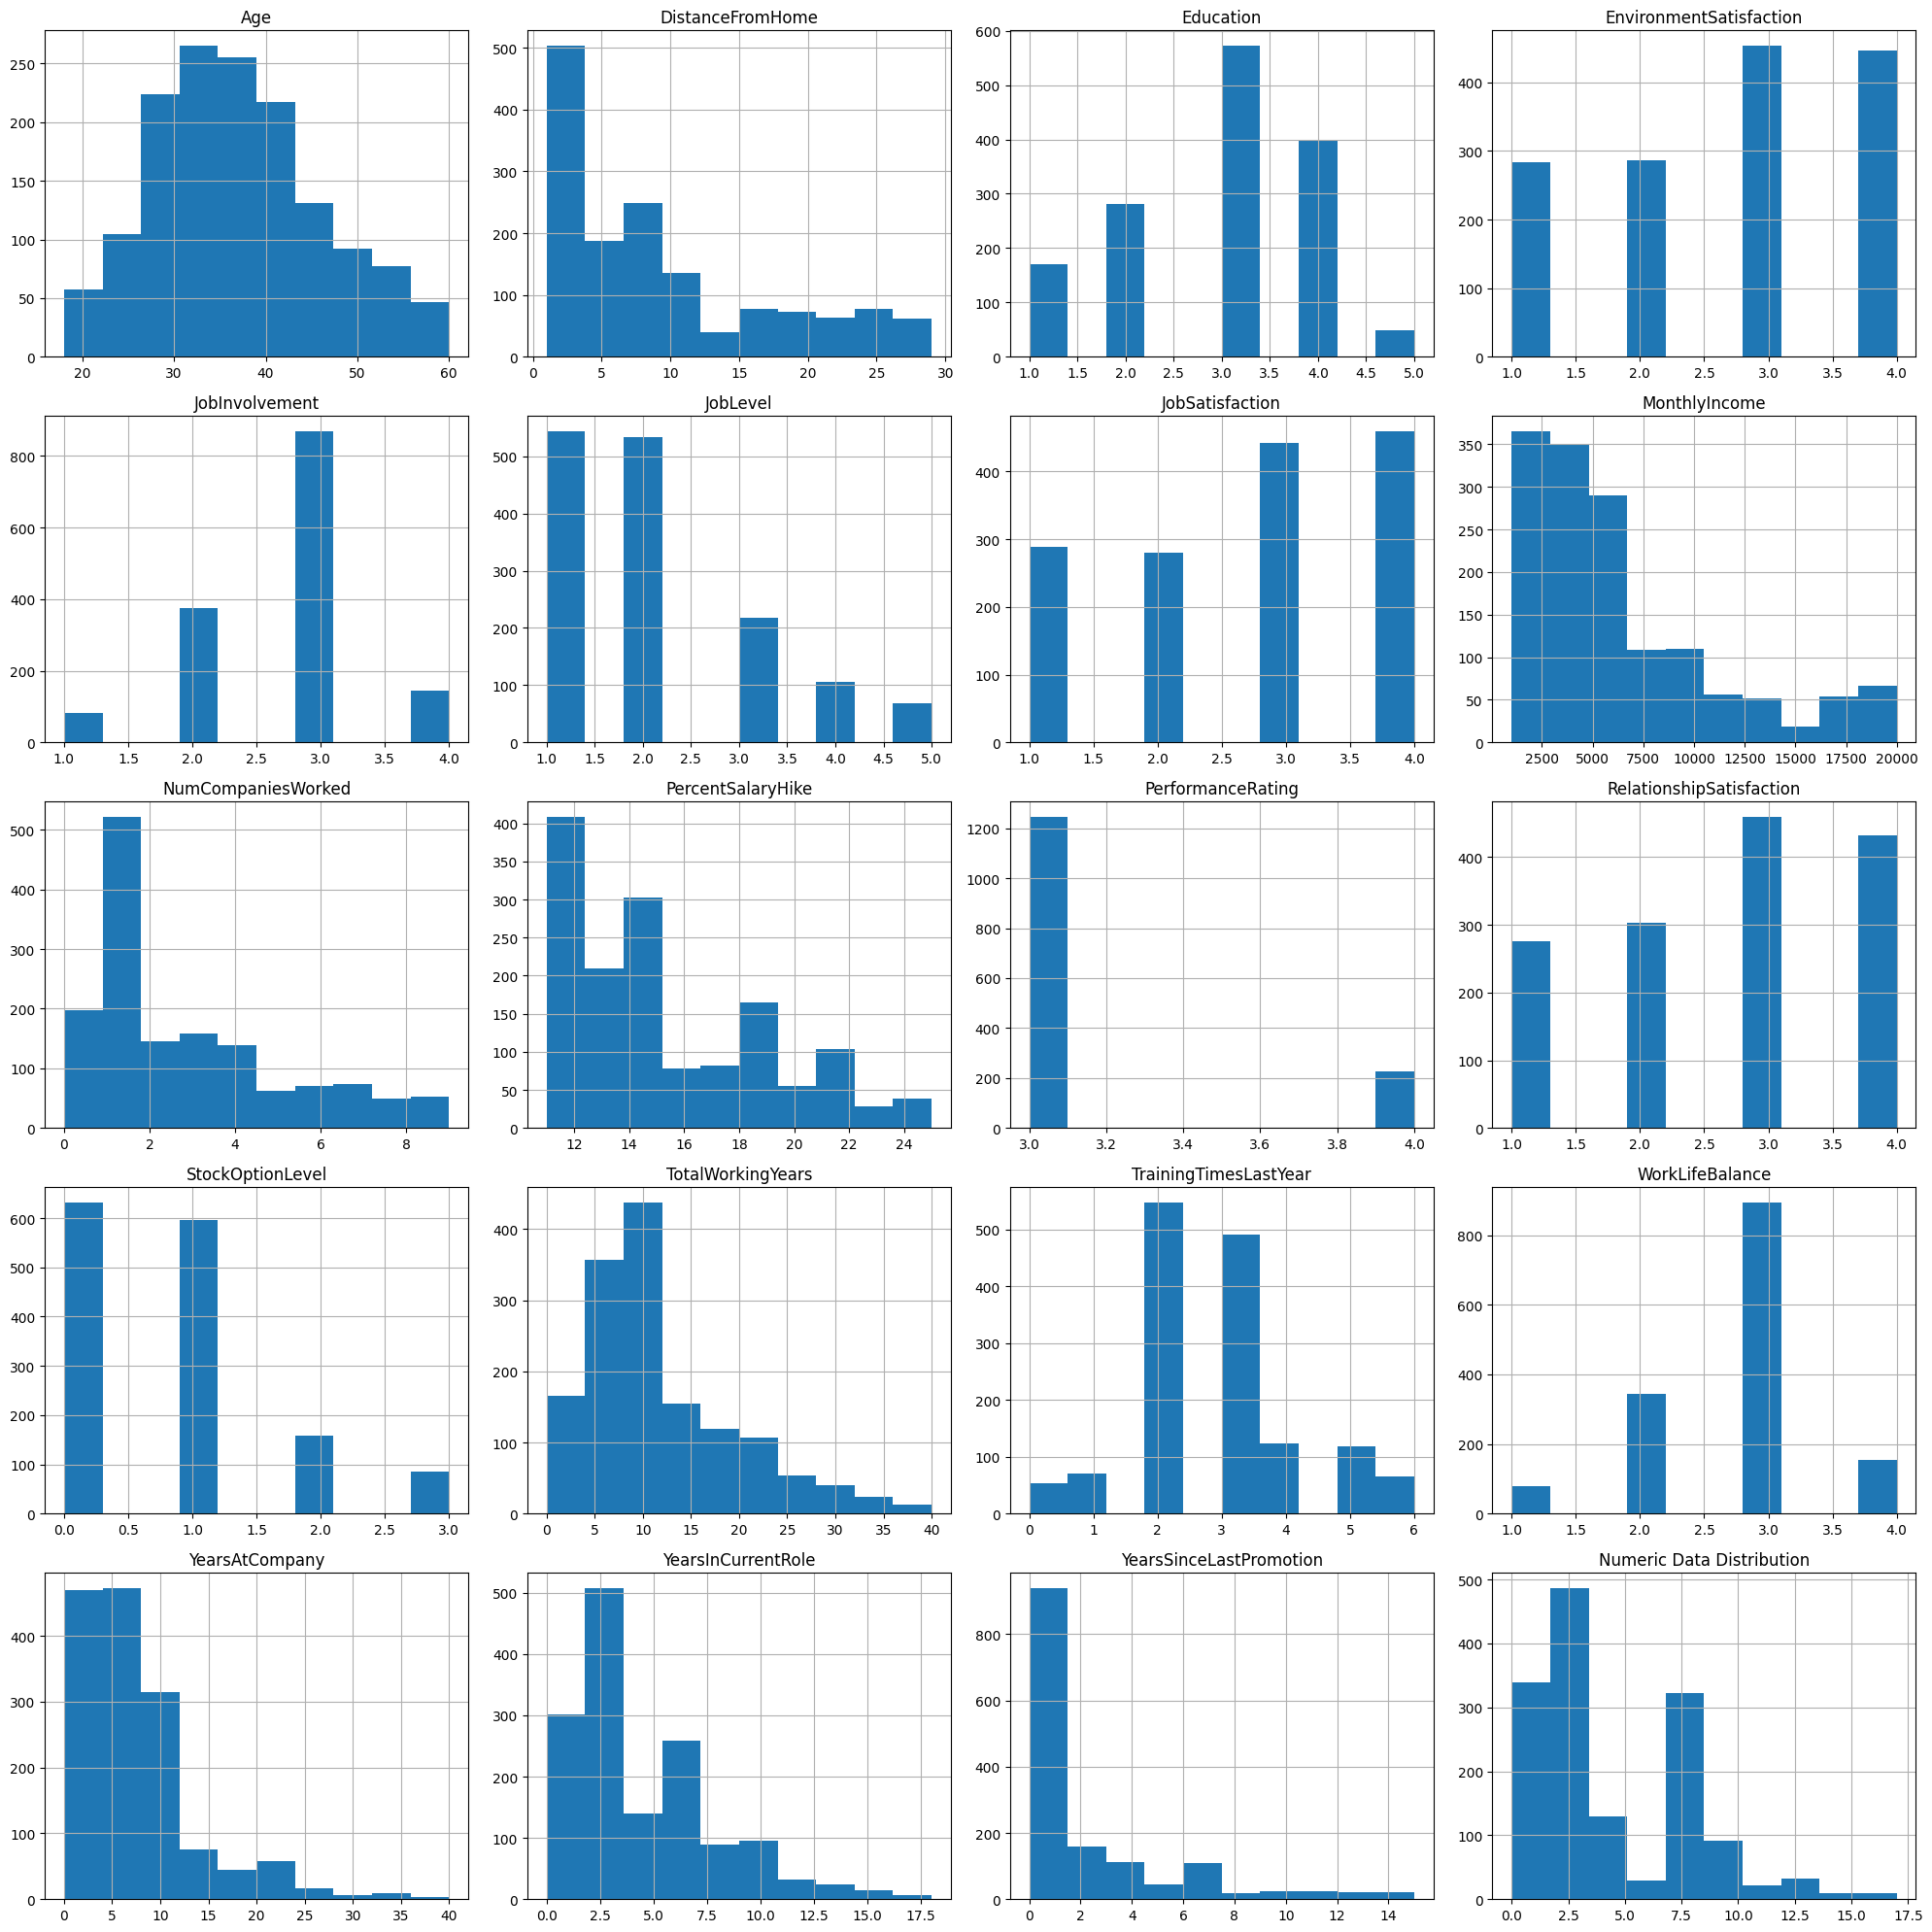

In [14]:
# 시각화
df_pandas = df.toPandas()

df_pandas.hist(figsize=(20,20))
plt.title("Numeric Data Distribution")
plt.tight_layout()
plt.show()

## 범주/문자형 데이터 확인 

In [15]:
string_cols = [
    "Attrition", "BusinessTravel","Department", "EducationField",
    "Gender", "JobRole", "MaritalStatus", "OverTime"
]
for col in string_cols:
    df.groupBy(col).count().show()

+---------+-----+
|Attrition|count|
+---------+-----+
|       No| 1233|
|      Yes|  237|
+---------+-----+

+-----------------+-----+
|   BusinessTravel|count|
+-----------------+-----+
|Travel_Frequently|  277|
|       Non-Travel|  150|
|    Travel_Rarely| 1043|
+-----------------+-----+

+--------------------+-----+
|          Department|count|
+--------------------+-----+
|               Sales|  446|
|Research & Develo...|  961|
|     Human Resources|   63|
+--------------------+-----+

+----------------+-----+
|  EducationField|count|
+----------------+-----+
|Technical Degree|  132|
|           Other|   82|
|       Marketing|  159|
|         Medical|  464|
|   Life Sciences|  606|
| Human Resources|   27|
+----------------+-----+

+------+-----+
|Gender|count|
+------+-----+
|Female|  588|
|  Male|  882|
+------+-----+

+--------------------+-----+
|             JobRole|count|
+--------------------+-----+
|     Sales Executive|  326|
|Manufacturing Dir...|  145|
|Laboratory Techn

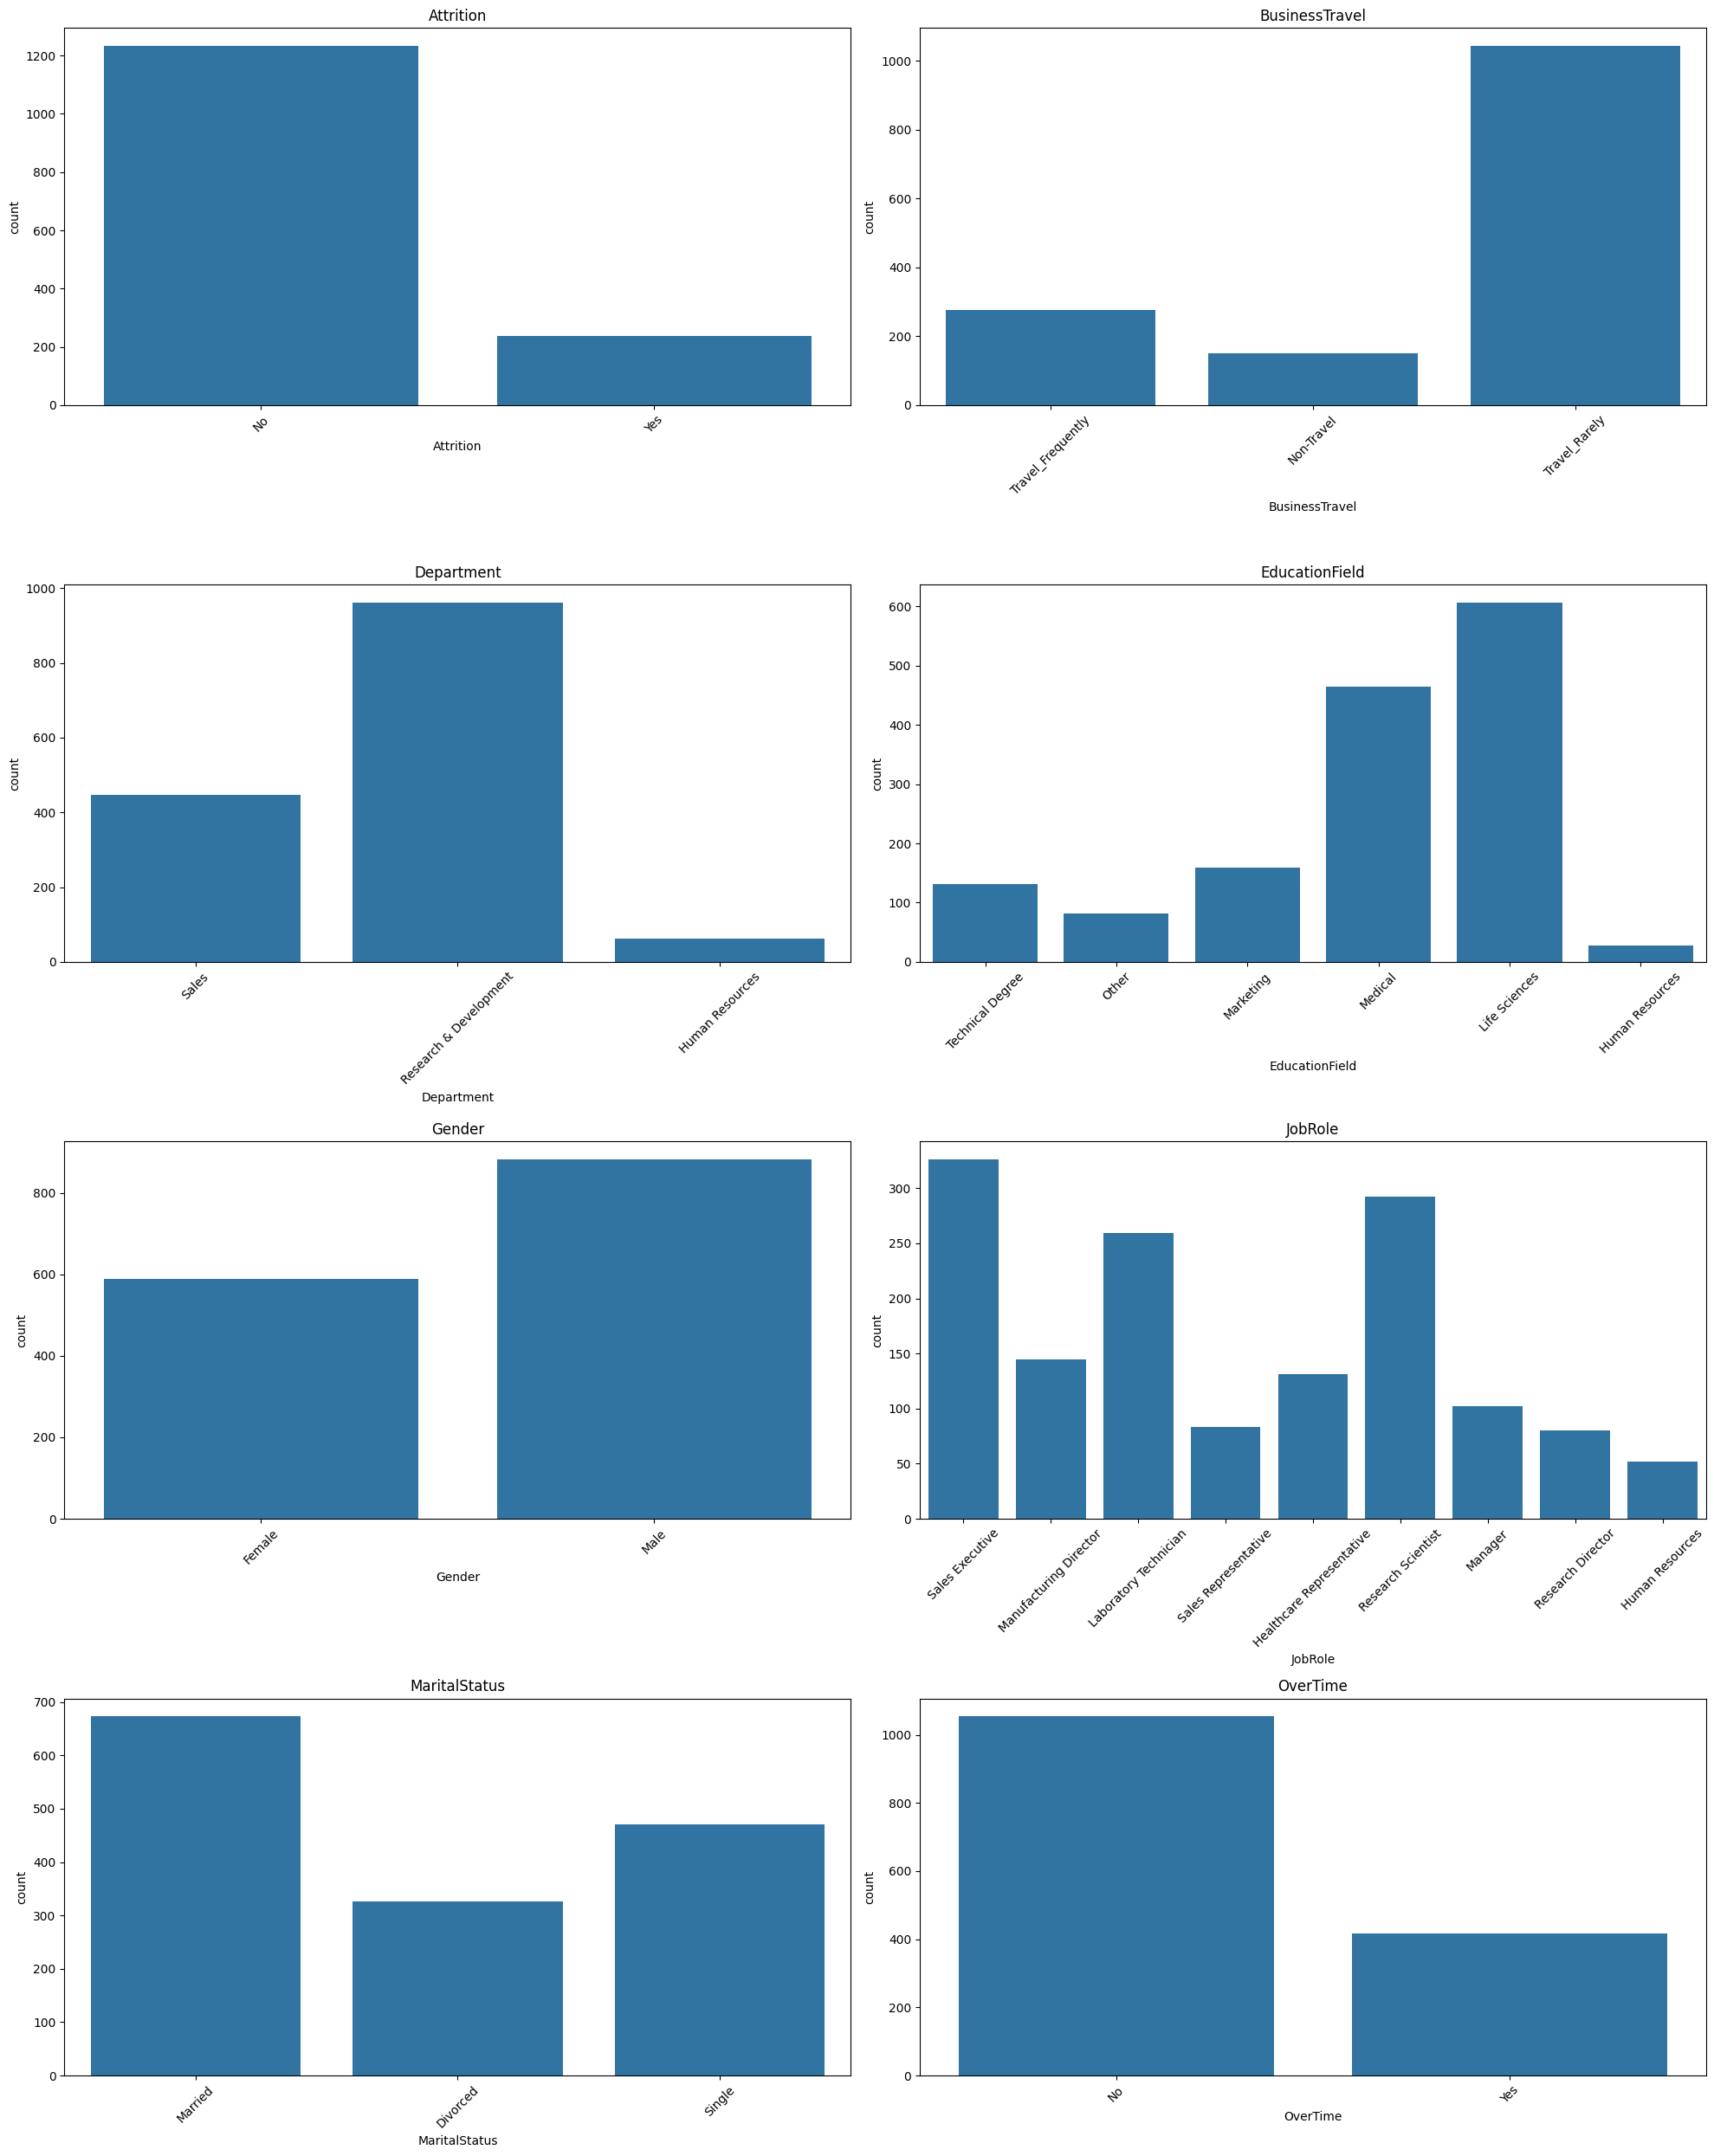

In [16]:
# 시각화

fig, axes = plt.subplots(4,2,figsize=(20,25))
axes = axes.flatten()
for i, col in enumerate(string_cols):
    string_cols_pandas = df.groupBy(col).count().toPandas()

    sns.barplot(x=col,y='count', data = string_cols_pandas, ax= axes[i])
    axes[i].set_title(f"{col}")
    axes[i].tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.show()

## 각 변수와 Attrition과의 연관성 분석
- 시각화
- "Attrition" 비욜의 불균형 여부 확인?

## 수치형 변수와 Attrition 간의 연관성

In [17]:
numeric_cols = [
    "Age", "DistanceFromHome", "Education", "EnvironmentSatisfaction",
    "JobInvolvement", "JobLevel", "JobSatisfaction", "MonthlyIncome",
    "NumCompaniesWorked", "PercentSalaryHike", "PerformanceRating",
    "RelationshipSatisfaction", "StockOptionLevel", "TotalWorkingYears",
    "TrainingTimesLastYear", "WorkLifeBalance", "YearsAtCompany",
    "YearsInCurrentRole", "YearsSinceLastPromotion", "YearsWithCurrManager"
]

In [18]:
# 'Attrition'을 수치형으로 변환
indexer = StringIndexer(inputCol="Attrition", outputCol="Attrition_index")
df_indexed = indexer.fit(df).transform(df)

In [19]:
# 수치형 변수들을 하나의 벡터로 결합
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_assembled = assembler.transform(df_indexed)
df_assembled

DataFrame[Age: int, Attrition: string, BusinessTravel: string, Department: string, DistanceFromHome: int, Education: int, EducationField: string, EnvironmentSatisfaction: int, Gender: string, JobInvolvement: int, JobLevel: int, JobRole: string, JobSatisfaction: int, MaritalStatus: string, MonthlyIncome: int, NumCompaniesWorked: int, OverTime: string, PercentSalaryHike: int, PerformanceRating: int, RelationshipSatisfaction: int, StockOptionLevel: int, TotalWorkingYears: int, TrainingTimesLastYear: int, WorkLifeBalance: int, YearsAtCompany: int, YearsInCurrentRole: int, YearsSinceLastPromotion: int, YearsWithCurrManager: int, Attrition_index: double, features: vector]

In [20]:
# Pearson 상관계수 계산
pearson_corr = Correlation.corr(df_assembled, 'features', method='pearson').head()
corr_matrix = pearson_corr[0].toArray()
print(corr_matrix)

24/12/19 14:46:30 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/12/19 14:46:30 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


[[ 1.00000000e+00 -1.68612015e-03  2.08033731e-01  1.01464279e-02
   2.98199586e-02  5.09604228e-01 -4.89187715e-03  4.97854567e-01
   2.99634758e-01  3.63358491e-03  1.90389551e-03  5.35347197e-02
   3.75097124e-02  6.80380536e-01 -1.96208189e-02 -2.14900280e-02
   3.11308770e-01  2.12901056e-01  2.16513368e-01  2.02088602e-01]
 [-1.68612015e-03  1.00000000e+00  2.10418256e-02 -1.60753270e-02
   8.78327989e-03  5.30273055e-03 -3.66883917e-03 -1.70144447e-02
  -2.92508042e-02  4.02353775e-02  2.71096185e-02  6.55747465e-03
   4.48719989e-02  4.62842586e-03 -3.69422343e-02 -2.65560041e-02
   9.50771990e-03  1.88449991e-02  1.00288359e-02  1.44060484e-02]
 [ 2.08033731e-01  2.10418256e-02  1.00000000e+00 -2.71283133e-02
   4.24376343e-02  1.01588886e-01 -1.12961167e-02  9.49606770e-02
   1.26316560e-01 -1.11109409e-02 -2.45387912e-02 -9.11837670e-03
   1.84222202e-02  1.48279697e-01 -2.51002411e-02  9.81918931e-03
   6.91136960e-02  6.02355541e-02  5.42543336e-02  6.90653783e-02]
 [ 1.01

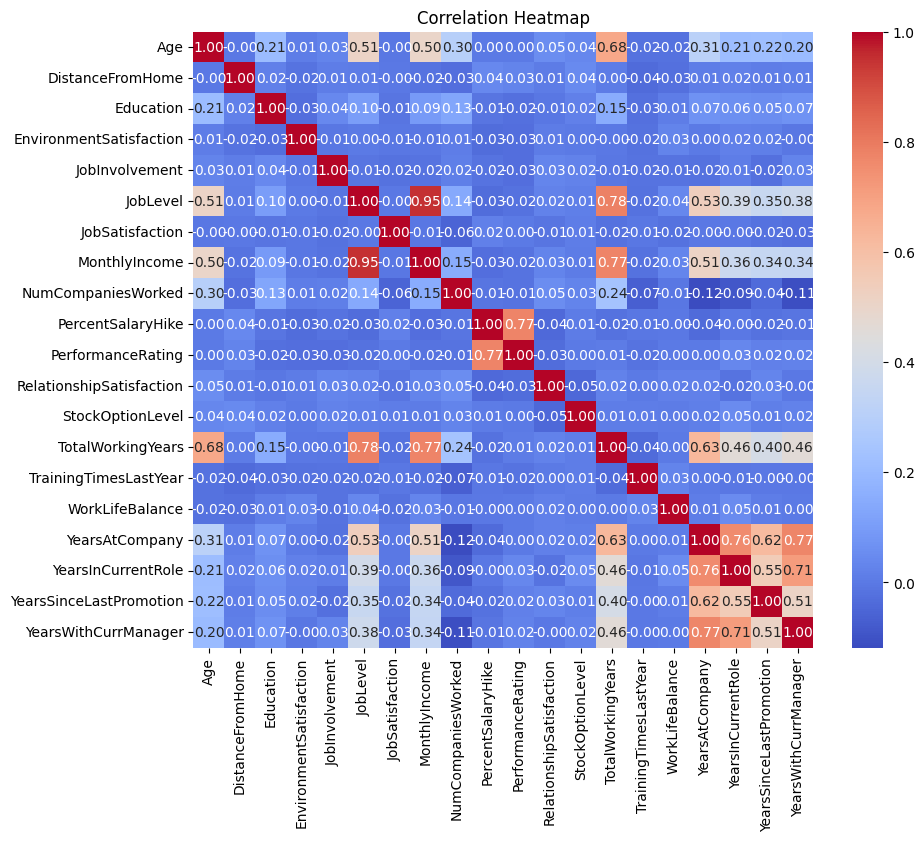

In [21]:
# 상관행렬 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', xticklabels=numeric_cols, yticklabels=numeric_cols)
plt.title("Correlation Heatmap")
plt.show()

/tmp/ipykernel_11503/865745575.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Attrition_index", y=col, data=df_pandas, ax=axes[i], palette='Set2')
/tmp/ipykernel_11503/865745575.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(['Stayed', 'Left'])  # 'Stayed'와 'Left' 레이블 설정
/tmp/ipykernel_11503/865745575.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Attrition_index", y=col, data=df_pandas, ax=axes[i], palette='Set2')
/tmp/ipykernel_11503/865745575.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(['Stayed', 'Left'])  # 'Stayed'와 'Left' 레이블 설정
/tmp/ipykernel

/tmp/ipykernel_11503/865745575.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(['Stayed', 'Left'])  # 'Stayed'와 'Left' 레이블 설정
/tmp/ipykernel_11503/865745575.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Attrition_index", y=col, data=df_pandas, ax=axes[i], palette='Set2')
/tmp/ipykernel_11503/865745575.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(['Stayed', 'Left'])  # 'Stayed'와 'Left' 레이블 설정
/tmp/ipykernel_11503/865745575.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Attrition_index", y=col, data=df_pandas, ax=axes[i], palette='Set2')
/tmp/ipykernel

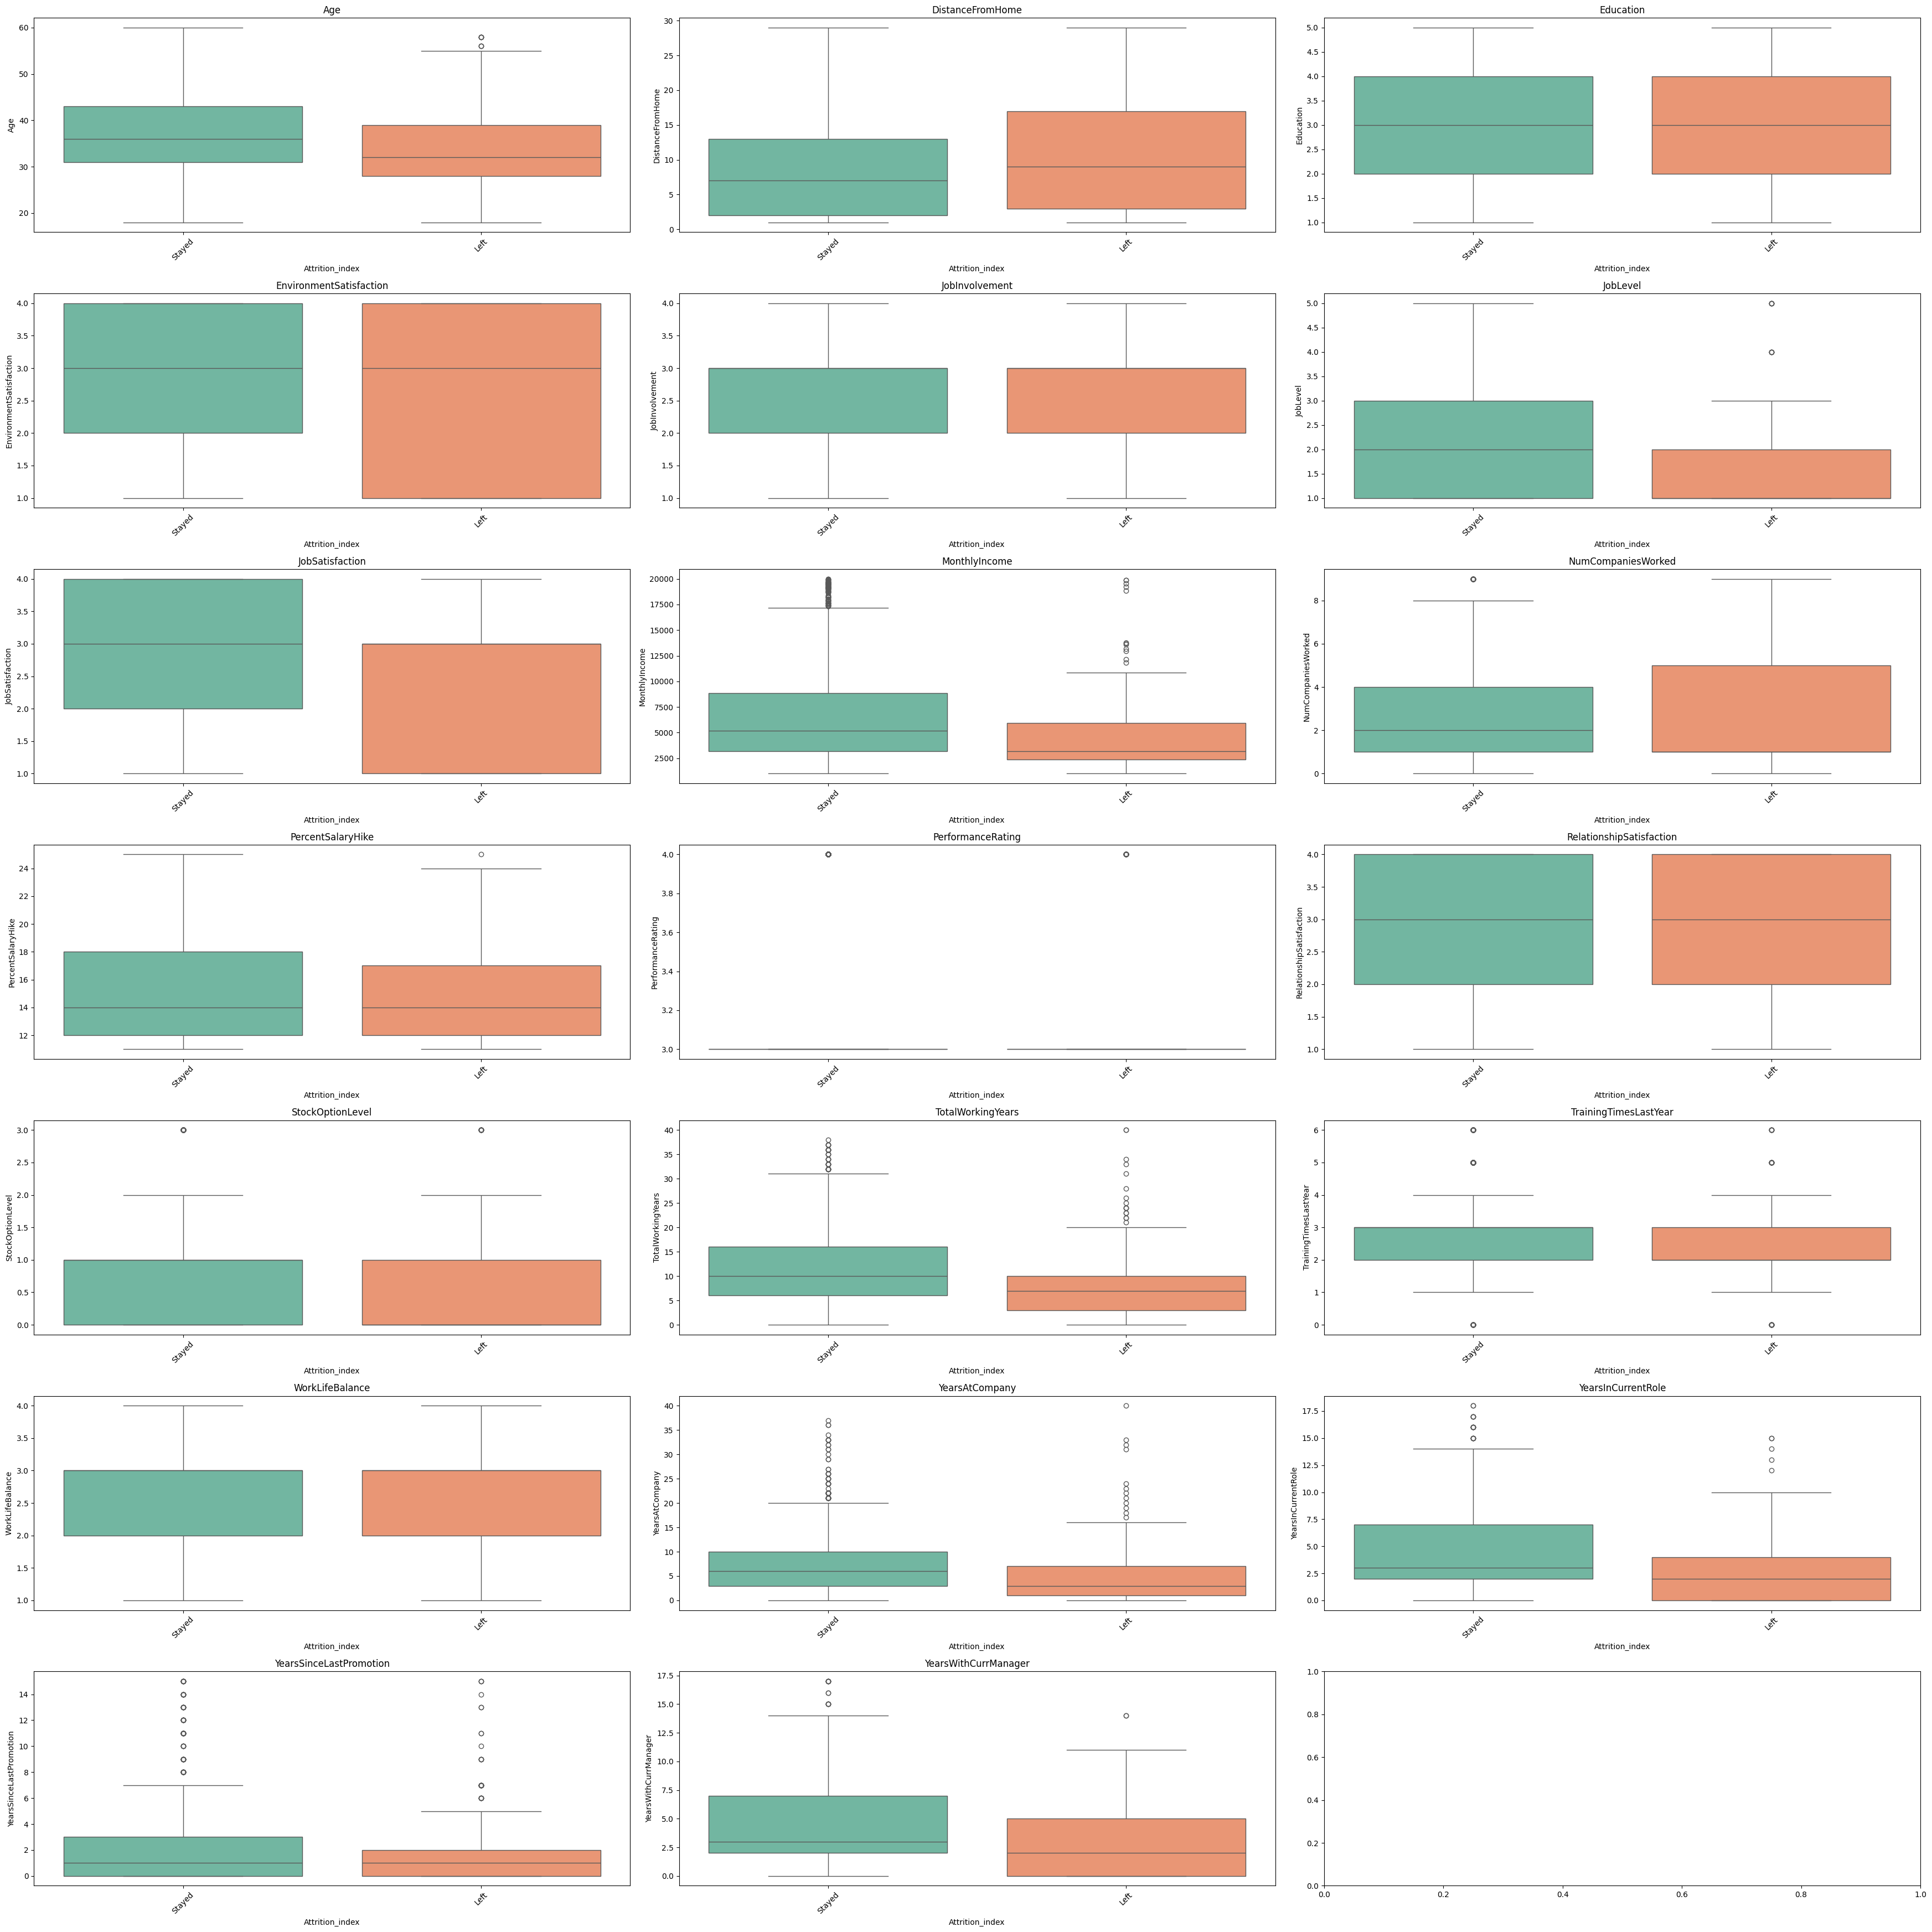

In [30]:
# 수치형 변수와 Attrition 간의 관계 박스플롯
# pandas DataFrame으로 변환
df_pandas = df_indexed.select("Attrition_index", *numeric_cols).toPandas()

# 5x4 그리드로 서브플롯 생성
fig, axes = plt.subplots(7,3, figsize=(35, 35))
axes = axes.flatten()

# 수치형 변수와 Attrition 간의 박스플롯 생성
for i, col in enumerate(numeric_cols):
    sns.boxplot(x="Attrition_index", y=col, data=df_pandas, ax=axes[i], palette='Set2')
    axes[i].set_title(f"{col}")
    axes[i].tick_params(axis='x', labelrotation=45)
    axes[i].set_xticklabels(['Stayed', 'Left'])  # 'Stayed'와 'Left' 레이블 설정

plt.tight_layout() 
plt.show()

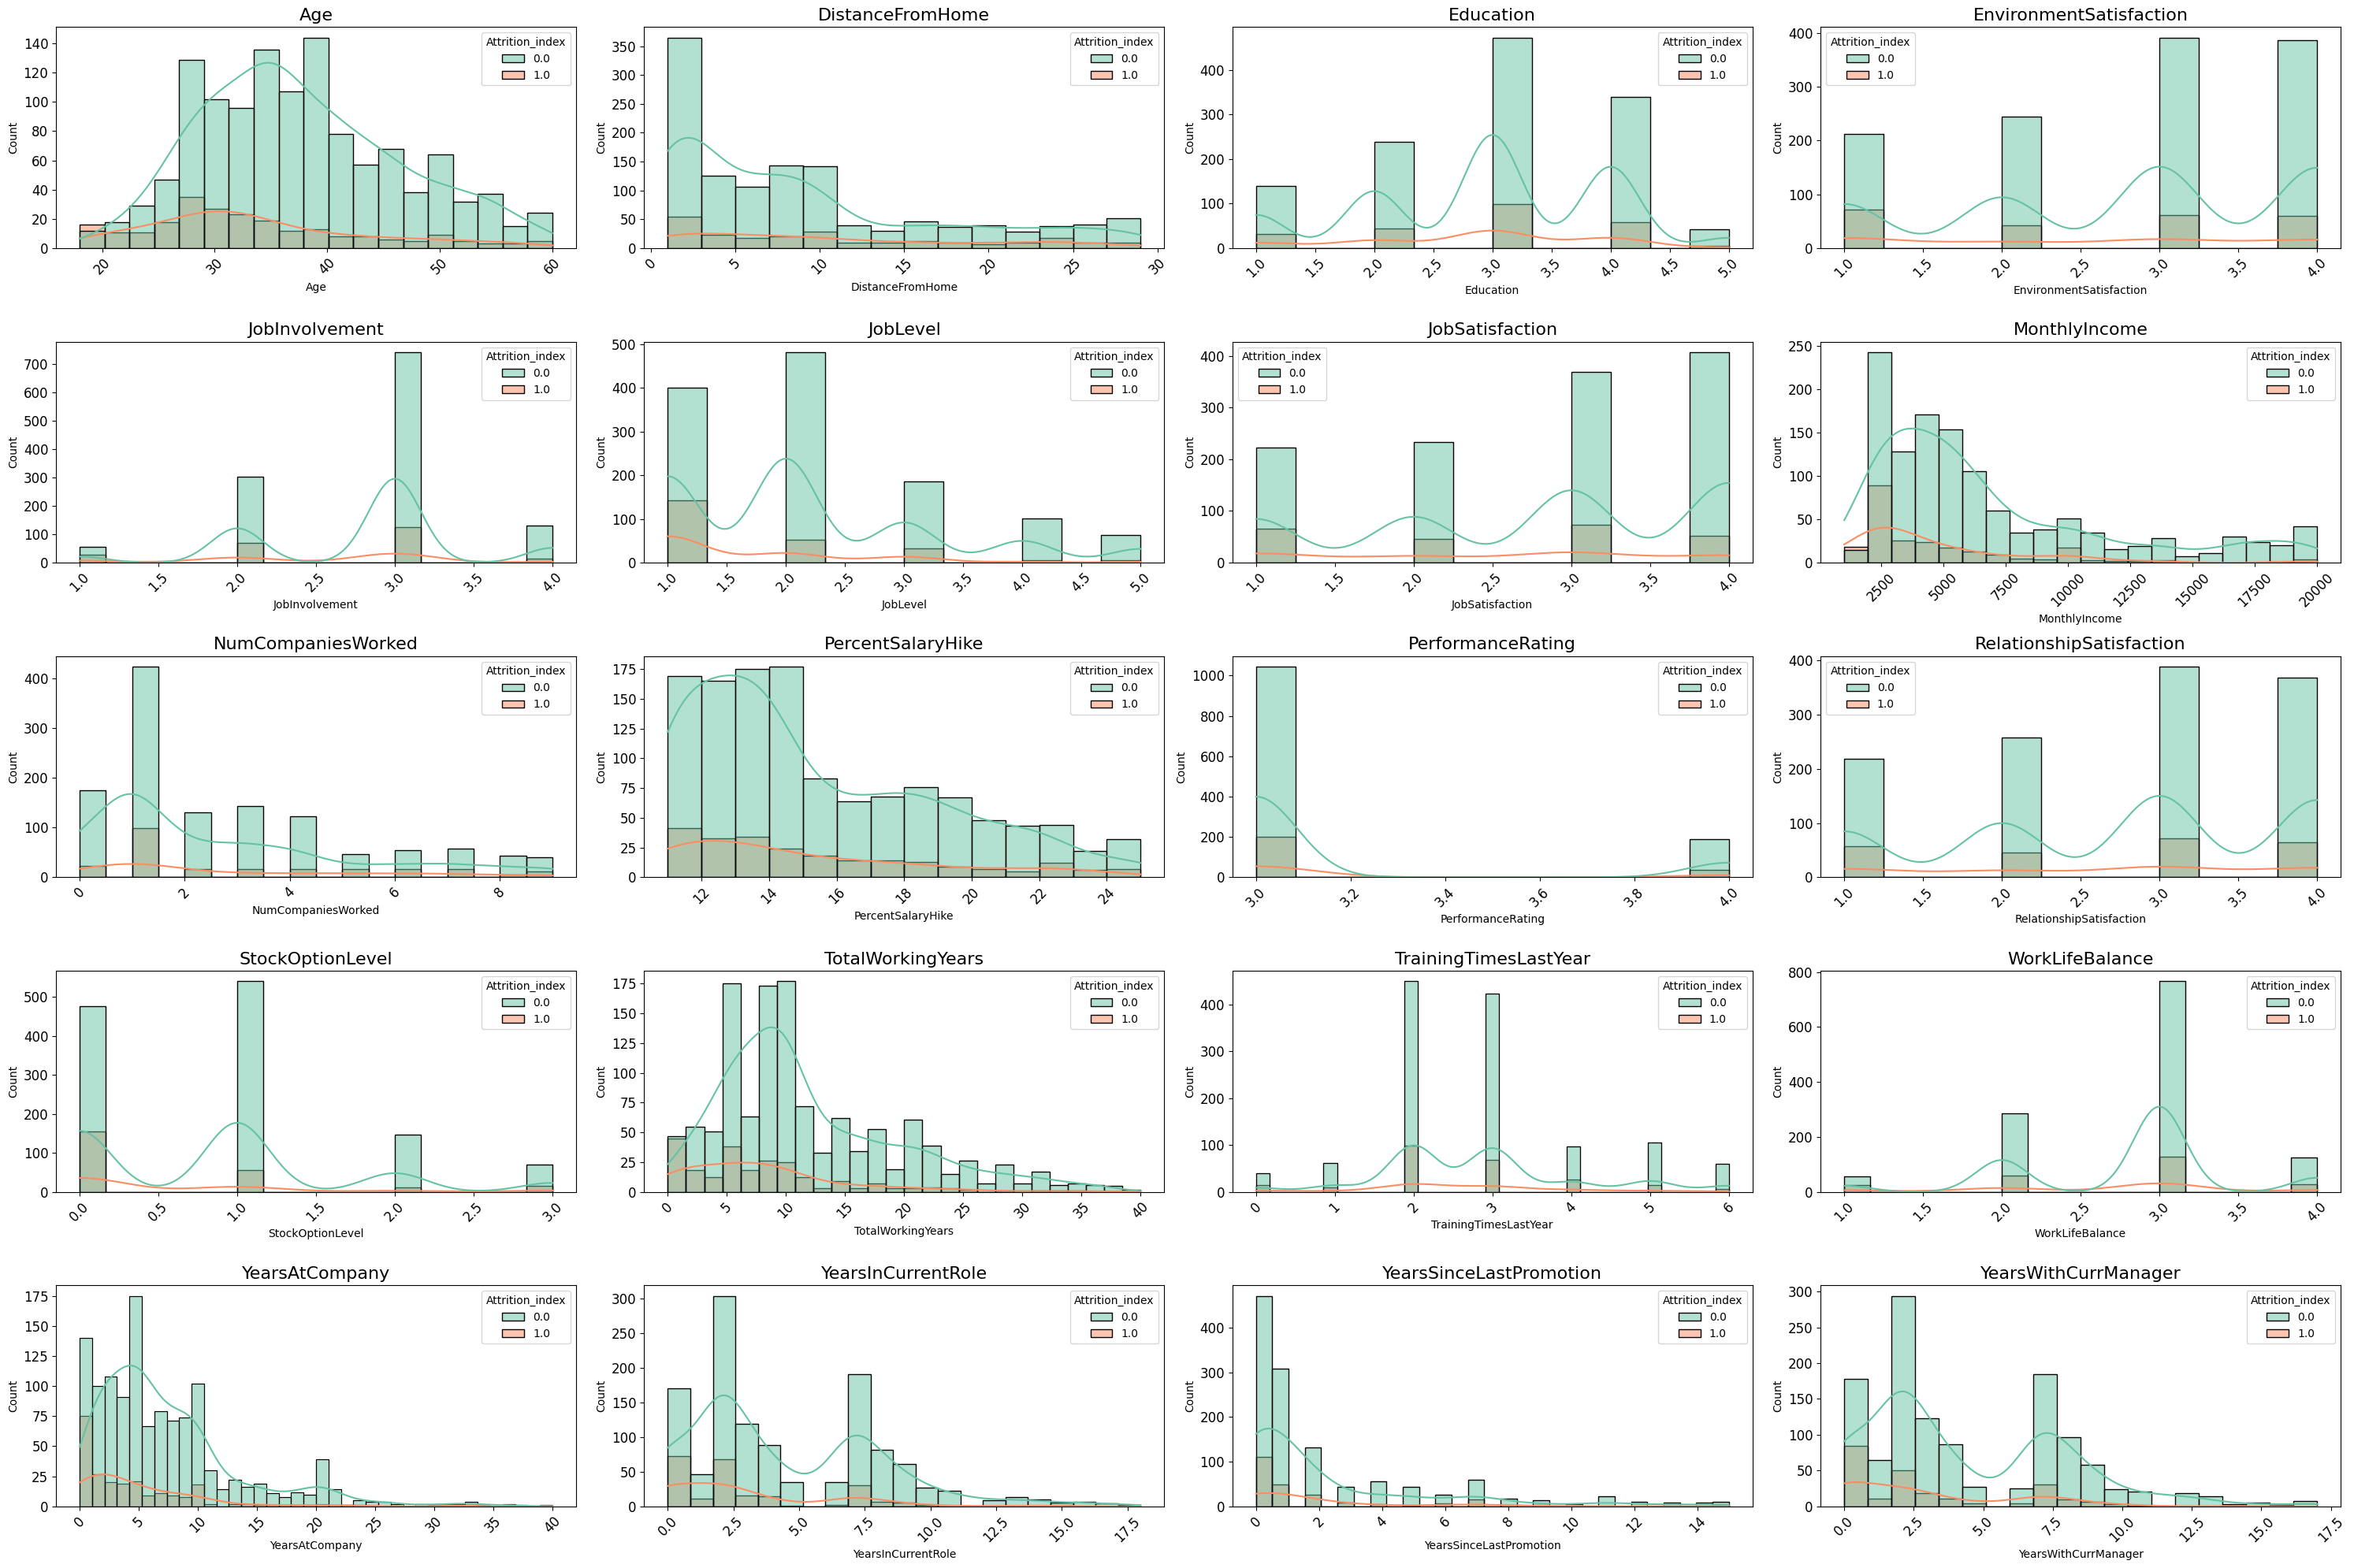

In [39]:
# pandas DataFrame으로 변환
df_pandas = df_indexed.select("Attrition_index", *numeric_cols).toPandas()

# 서브플롯 생성 (5x4 그리드, 크기 조정)
fig, axes = plt.subplots(5, 4, figsize=(30, 20))  # 크기를 키움
axes = axes.flatten()

# 각 수치형 변수에 대해 히스토그램 생성
for i, col in enumerate(numeric_cols):
    sns.histplot(data=df_pandas, x=col, hue='Attrition_index', ax=axes[i], palette="Set2", kde=True)
    axes[i].set_title(f"{col}", fontsize=16)  # 제목 글씨 크기 조정
    axes[i].tick_params(axis='x', labelrotation=45, labelsize=12)  # x축 레이블 회전 및 크기 조정
    axes[i].tick_params(axis='y', labelsize=12)  # y축 레이블 크기 조정

# 남는 서브플롯 제거
for j in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 범주형 변수와 Attrition 간의 연관성

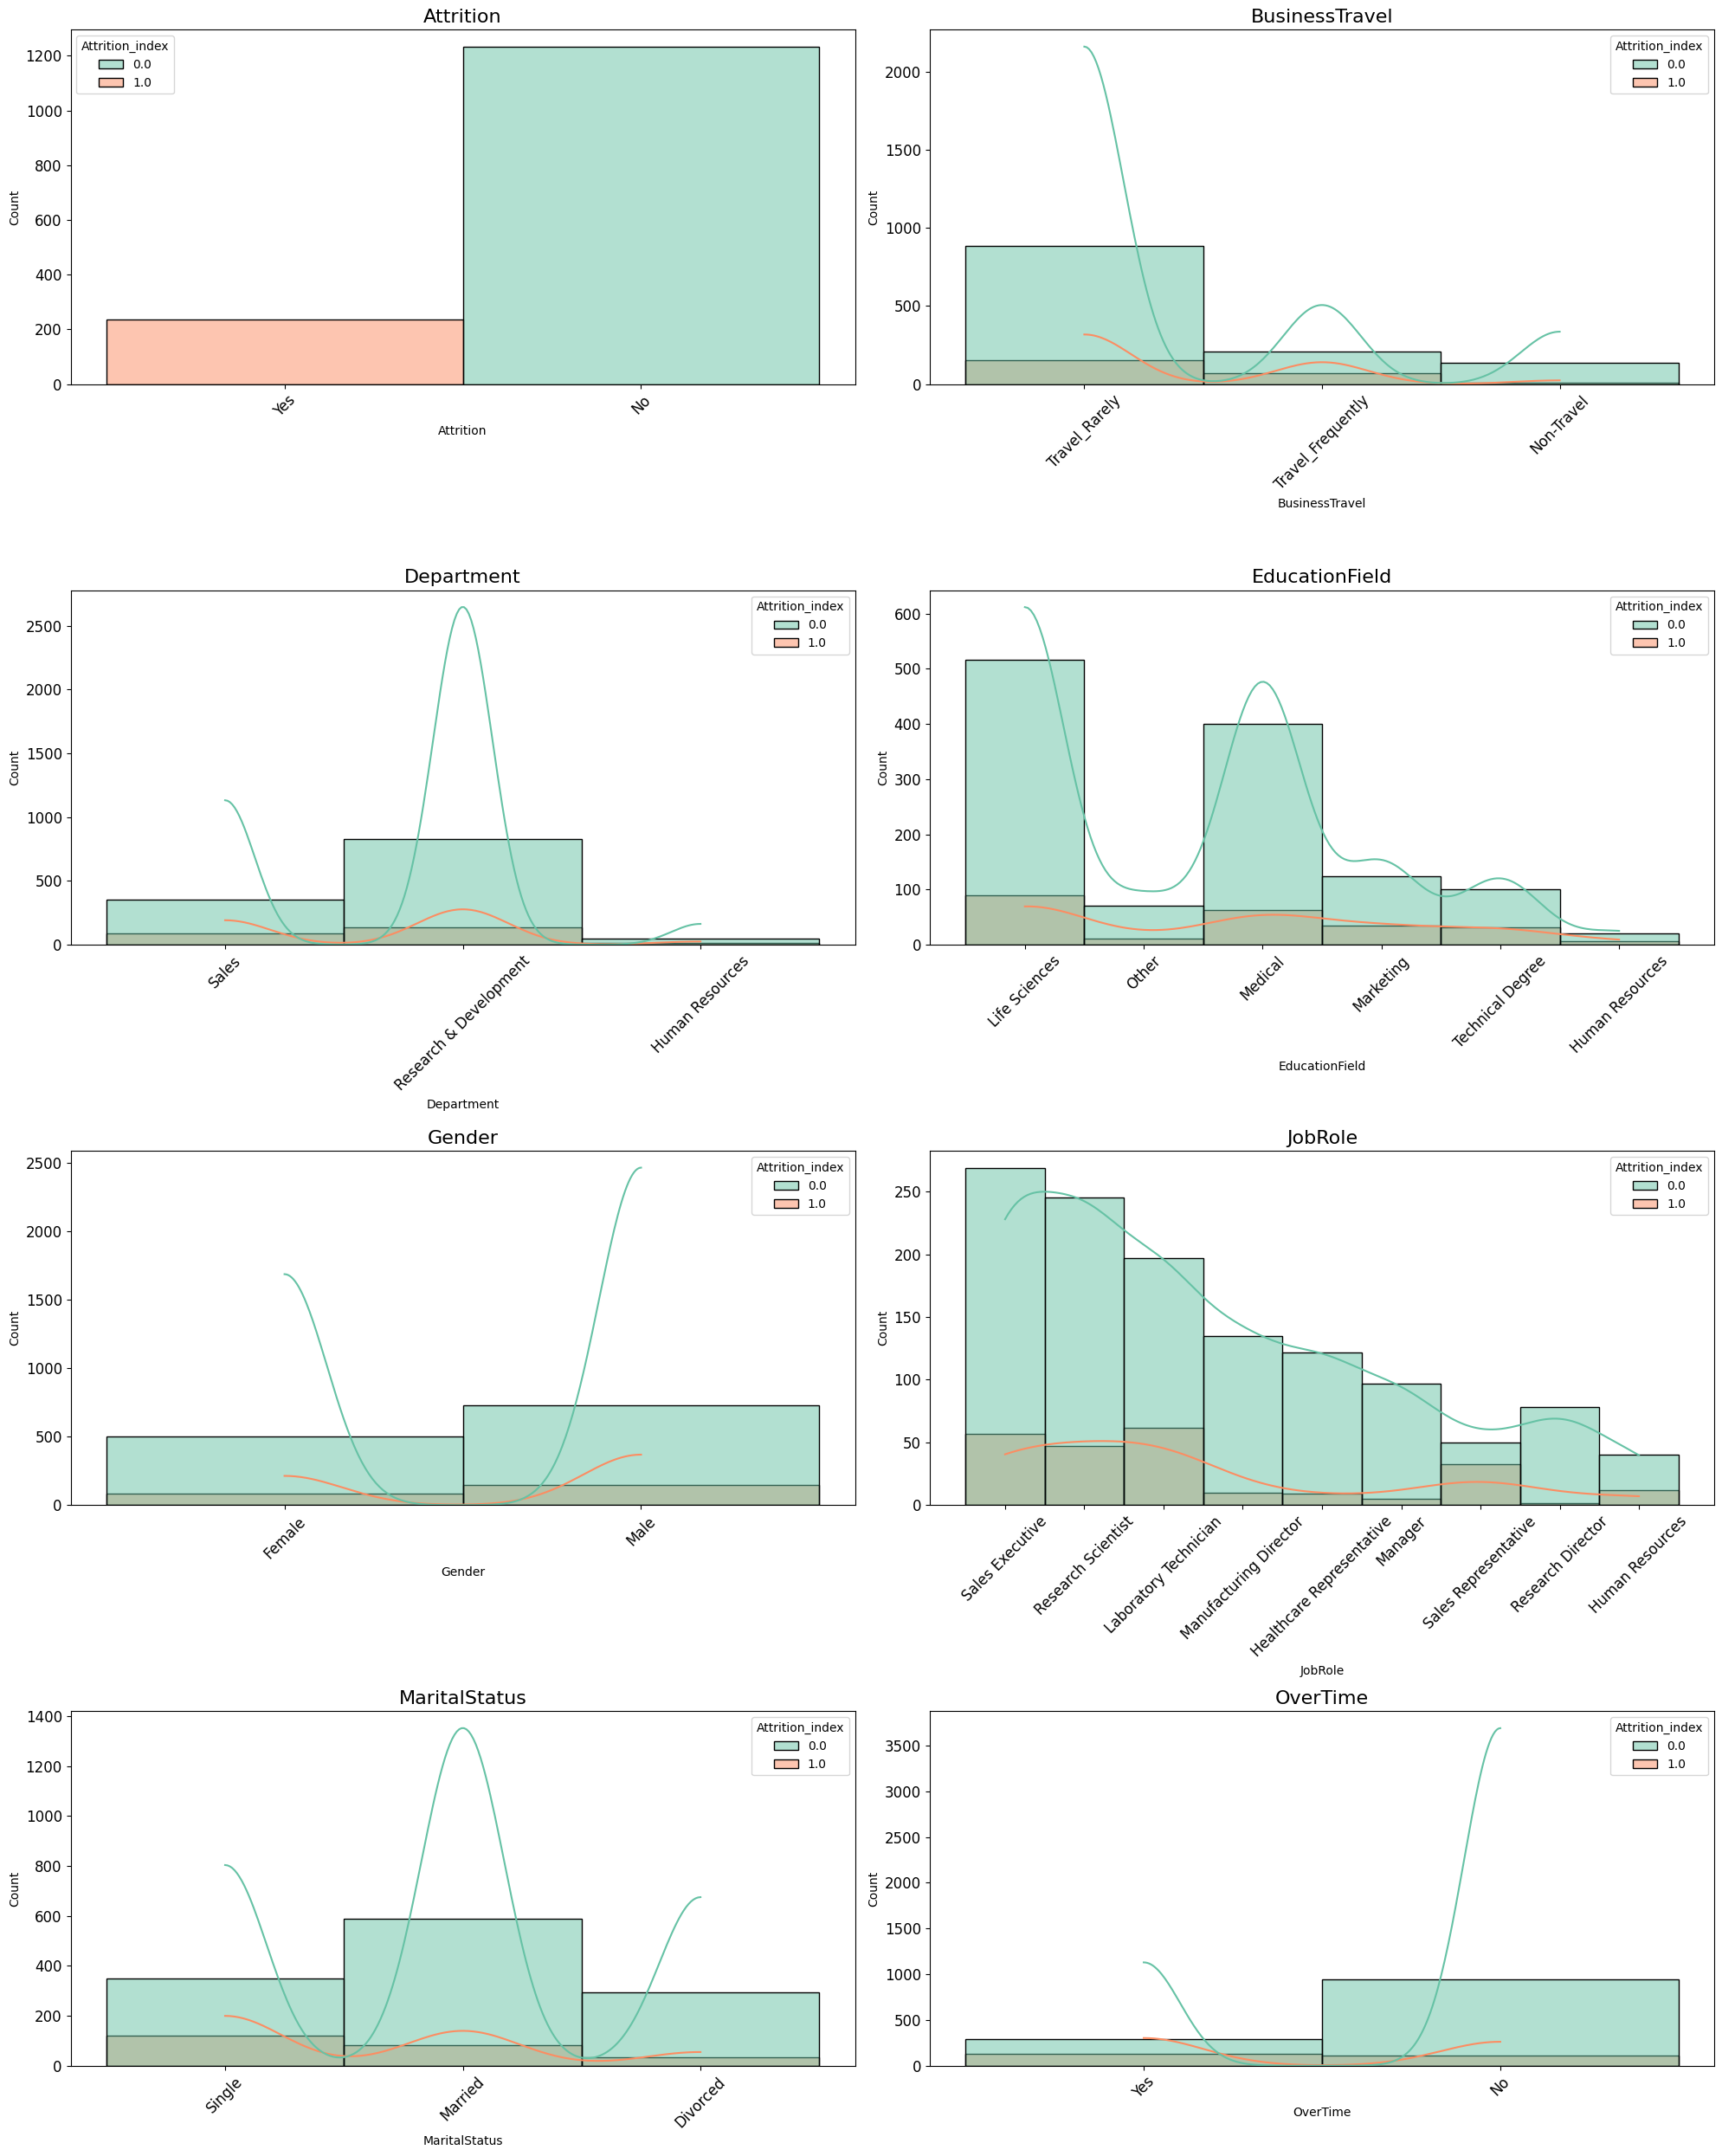

In [46]:
# pandas DataFrame으로 변환
df_pandas = df_indexed.select("Attrition_index", *string_cols).toPandas()

# 서브플롯 생성 (5x4 그리드, 크기 조정)
fig, axes = plt.subplots(4,2, figsize=(20, 25))  # 크기를 키움
axes = axes.flatten()

# 각 수치형 변수에 대해 히스토그램 생성
for i, col in enumerate(string_cols):
    sns.histplot(data=df_pandas, x=col, hue='Attrition_index', ax=axes[i], palette="Set2", kde=True)
    axes[i].set_title(f"{col}", fontsize=16)  # 제목 글씨 크기 조정
    axes[i].tick_params(axis='x', labelrotation=45, labelsize=12)  # x축 레이블 회전 및 크기 조정
    axes[i].tick_params(axis='y', labelsize=12)  # y축 레이블 크기 조정
plt.tight_layout()
plt.show()

# 가설 확인

- 가설 1: MonthlyIncome이 낮으면 Attrition(이직률)이 높을 가능성이 있다.
- 가설 2: JobSatisfaction이 낮으면 Attrition이 높을 가능성이 있다.
- 가설 3: OverTime이 "Yes"인 경우 Attrition이 높을 가능성이 있다.

## 가설 1

+---------+--------------------+
|Attrition|AverageMonthlyIncome|
+---------+--------------------+
|       No|   6832.739659367397|
|      Yes|  4787.0928270042195|
+---------+--------------------+



<Figure size 800x600 with 0 Axes>

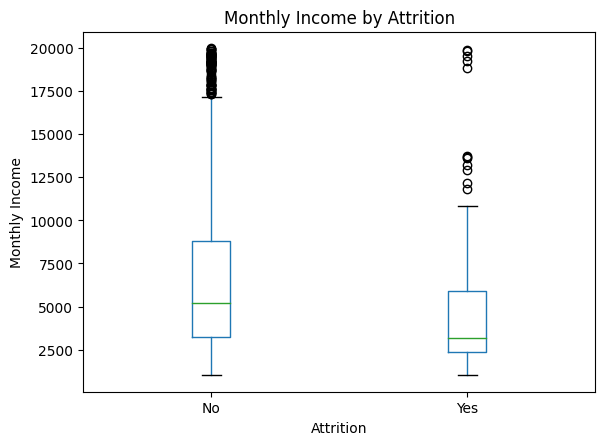

In [12]:
df.groupBy("Attrition").agg(avg("MonthlyIncome").alias("AverageMonthlyIncome")).show()

df_pandas = df.toPandas()

# Boxplot 생성
plt.figure(figsize=(8, 6))
df_pandas.boxplot(by="Attrition", column="MonthlyIncome", grid=False)
plt.title("Monthly Income by Attrition")
plt.suptitle("")
plt.xlabel("Attrition")
plt.ylabel("Monthly Income")
plt.show()

### Monthly Income 과 Attrition 분석 
- 이직한 직원 (Attrition = Yes) 에서 월급의 중앙값은 이직하지 않은 직원보다 낮음
- 분포가 더 좁으며 대부분의 데이터가 하위 구간에 집중
- 낮은 월급을 받는 직원들이 이직할 가능성이 더 높아 보임
- 다른 변수와의 상호작용 분석: 월급 외에도 초과 근무 ("Over Time"), 직무 만족도 ("Job Satisfaction") 과 함께 분석해보기 

+---------------+---------+-----+--------------------+
|JobSatisfaction|Attrition|count|       AttritionRate|
+---------------+---------+-----+--------------------+
|              1|       No|  223| 0.15170068027210884|
|              1|      Yes|   66|0.044897959183673466|
|              2|       No|  234| 0.15918367346938775|
|              2|      Yes|   46|0.031292517006802724|
|              3|      Yes|   73| 0.04965986394557823|
|              3|       No|  369|  0.2510204081632653|
|              4|       No|  407| 0.27687074829931974|
|              4|      Yes|   52| 0.03537414965986395|
+---------------+---------+-----+--------------------+



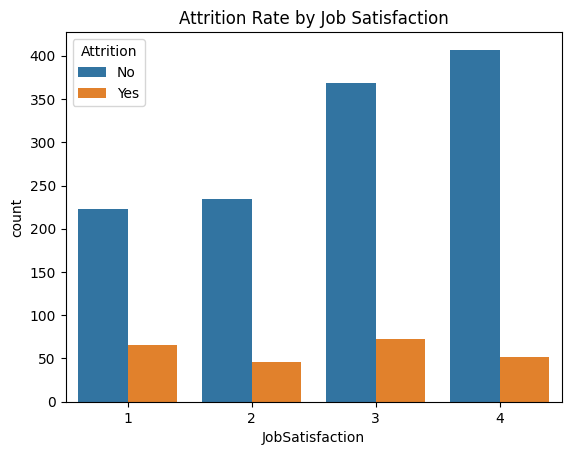

In [11]:
from pyspark.sql.functions import col

# JobSatisfaction별 Attrition 비율 계산
df.groupBy("JobSatisfaction", "Attrition").count() \
    .withColumn("AttritionRate", col("count") / df.count()) \
    .orderBy("JobSatisfaction").show()

# Pandas로 변환 후 시각화 (옵션)
df_pandas = df.groupBy("JobSatisfaction", "Attrition").count().toPandas()
sns.barplot(x="JobSatisfaction", y="count", hue="Attrition", data=df_pandas)
plt.title("Attrition Rate by Job Satisfaction")
plt.show()

+--------+---------+-----+
|OverTime|Attrition|count|
+--------+---------+-----+
|     Yes|      Yes|  127|
|      No|       No|  944|
|     Yes|       No|  289|
|      No|      Yes|  110|
+--------+---------+-----+



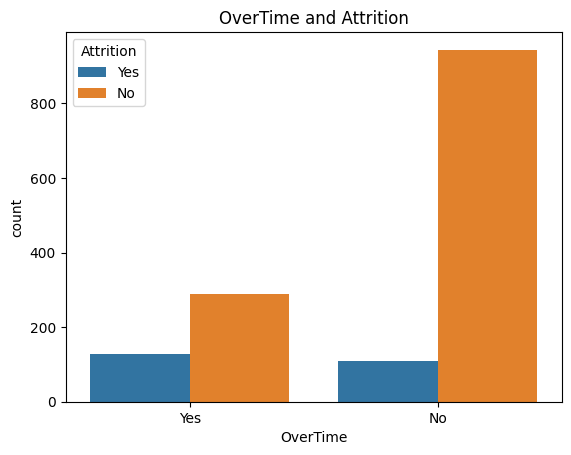

In [15]:
# OverTime 여부별 Attrition 비율
df.groupBy("OverTime", "Attrition").count().show()

df_pandas = df.toPandas()

sns.countplot(x="OverTime", hue="Attrition", data=df_pandas)
plt.title("OverTime and Attrition")
plt.show()

In [17]:
# 상관관계 분석 - 피어슨 상관 계수를 사용 - 연속형 변수 간의 관계 분석, 높은 상관 관계를 가진 변수들 중 하나를 선택

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col

# 범주형 컬럼을 수치형으로 변환 (StringIndexer)
indexers = [StringIndexer(inputCol=col_name, outputCol=f"{col_name}_index") for col_name in category_cols]
pipeline = Pipeline(stages=indexers)
df_indexed = pipeline.fit(df).transform(df)

# 수치형과 범주형 변환된 컬럼을 결합
numeric_cols = numeric_cols + [f"{col_name}_index" for col_name in category_cols]
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_assembled = assembler.transform(df_indexed)


# Pearson 상관행렬 계산
pearson_corr = Correlation.corr(df_assembled, 'features', method='pearson').head()
corr_matrix = pearson_corr[0].toArray()
print(corr_matrix)

NameError: name 'category_cols' is not defined

In [ ]:
# 변수 중요도 평가 - 모델 학습 후, 각 특성의 중요도 출력 이직 예측에 중요한 특성을 선택
# - 랜덤 포레스트
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="Attrition_Index", featuresCol="features")
model = rf.fit(df)
importance = model.featureImportances
feature_names = numeric_cols
importance_df = list(zip(feature_names, importance))
importance_df.sort(key=lambda x: x[1], reverse=True)
print(importance_df)

In [ ]:
# 상대적 정보 이득
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

df_pandas = df.toPandas()
X = df_pandas[numeric_cols]
y = df_pandas['Attrition_Index']
mi = mutual_info_classif(X, y)
mi_df = pd.DataFrame({"Feature": numeric_cols, "Mutual Information": mi})
mi_df = mi_df.sort_values(by="Mutual Information", ascending=False)
print(mi_df)

# 머신러닝 모델 생성 및 예측

In [18]:
numeric_cols = ["JobSatisfaction", "MonthlyIncome"]

string_cols = [
    "Attrition", "OverTime"
]

In [19]:
# StringIndexer를 사용하여 범주형 컬럼을 숫자형으로 변환
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in string_cols]

# OneHotEncoder를 사용하여 범주형 컬럼을 원-핫 인코딩
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_encoded") for col in string_cols]

# 문자형(인코딩) + 숫자형 피처를 겨람한 모델 입력 생성
assembler_inputs = [col+"_encoded" for col in string_cols] + numeric_cols
assembler = VectorAssembler(inputCols= assembler_inputs, outputCol="features", handleInvalid='skip')

# 파이프라인에 모든 스테이지 추가
pipeline = Pipeline(stages=indexers + encoders + [assembler])

# 데이터 변환
df_transformed = pipeline.fit(df).transform(df)

In [20]:
# 훈련 데이터와 테스트 데이터 분리
train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)

# 로지스틱 회귀 모델
lr = LogisticRegression(featuresCol='features', labelCol='Attrition_index')

# 모델 훈련
model = lr.fit(train_data)

# 예측 수행
predictions = model.transform(test_data)

# 예측 성능 평가
evaluator = BinaryClassificationEvaluator(labelCol='Attrition_index')
auc = evaluator.evaluate(predictions)
auc 
# 1차 결과값 = 0.6718963831867062 - 기본 예측보다는 나은 성능이지만 개선의 여지가 많음 - 아직 최적화디지 않음
# 2차 결과값 = 0.7806940371456519

IllegalArgumentException: features does not exist. Available: Age, Attrition, BusinessTravel, Department, DistanceFromHome, Education, EducationField, EnvironmentSatisfaction, Gender, JobInvolvement, JobLevel, JobRole, JobSatisfaction, MaritalStatus, MonthlyIncome, NumCompaniesWorked, OverTime, PercentSalaryHike, PerformanceRating, RelationshipSatisfaction, StockOptionLevel, TotalWorkingYears, TrainingTimesLastYear, WorkLifeBalance, YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion, YearsWithCurrManager

In [ ]:
predictions.printSchema()

In [ ]:
predictions.select('Attrition','Attrition_Index', 'prediction', 'probability').show(truncate=False)

- Attrition, Attrition_Index: 실제 레이블 (No 0, Yes 1)
- prediction: 모델의 예츨 결과 (No 0, Yes 1)
- probability: 예측 확률 - 첫번째 No 일 확률, 두번째 Yes 일 확률